### 初始化

In [2]:
data_path = "/home/sonwe1e/WorkStation/Dataset/MNIST/"
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

data = np.load(data_path + "mnist.npz")["x_train"]
data = torch.from_numpy(data).float()
data = data.unsqueeze(1) / data.max()
data = transforms.Resize((32, 32))(data)
print(data.shape, data.max())

torch.Size([60000, 1, 32, 32]) tensor(1.)


/home/sonwe1e/miniconda3/envs/cv2d/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### 训练 DDPM 模型

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beta1, betaT, T = 1e-4, 1e-2, 1000
betas = torch.linspace(beta1, betaT, T).to(device)
alphas = (1 - betas).to(device)
alphas_bar = torch.cumprod(alphas, dim=0).to(device)
alphas_bar_prev = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]]).to(
    device
)


def get_noise_image(x, t):
    sqrt_alphas_hat = torch.sqrt(alphas_bar[t])
    sqrt_one_minus_alphas_hat = torch.sqrt(1 - alphas_bar[t])
    noise = torch.randn_like(x)
    return (
        sqrt_alphas_hat[:, None, None, None] * x
        + sqrt_one_minus_alphas_hat[:, None, None, None] * noise,
        noise,
    )

  0%|          | 0/117 [00:00<?, ?it/s]

100%|██████████| 117/117 [00:16<00:00,  6.89it/s]


Finished epoch 0. Average loss for this epoch: 0.11800


100%|██████████| 117/117 [00:16<00:00,  6.89it/s]


Finished epoch 1. Average loss for this epoch: 0.03296


100%|██████████| 117/117 [00:16<00:00,  6.89it/s]


Finished epoch 2. Average loss for this epoch: 0.02819


100%|██████████| 117/117 [00:17<00:00,  6.87it/s]


Finished epoch 3. Average loss for this epoch: 0.02577


100%|██████████| 117/117 [00:17<00:00,  6.88it/s]

Finished epoch 4. Average loss for this epoch: 0.02416


(0.0, 0.1)

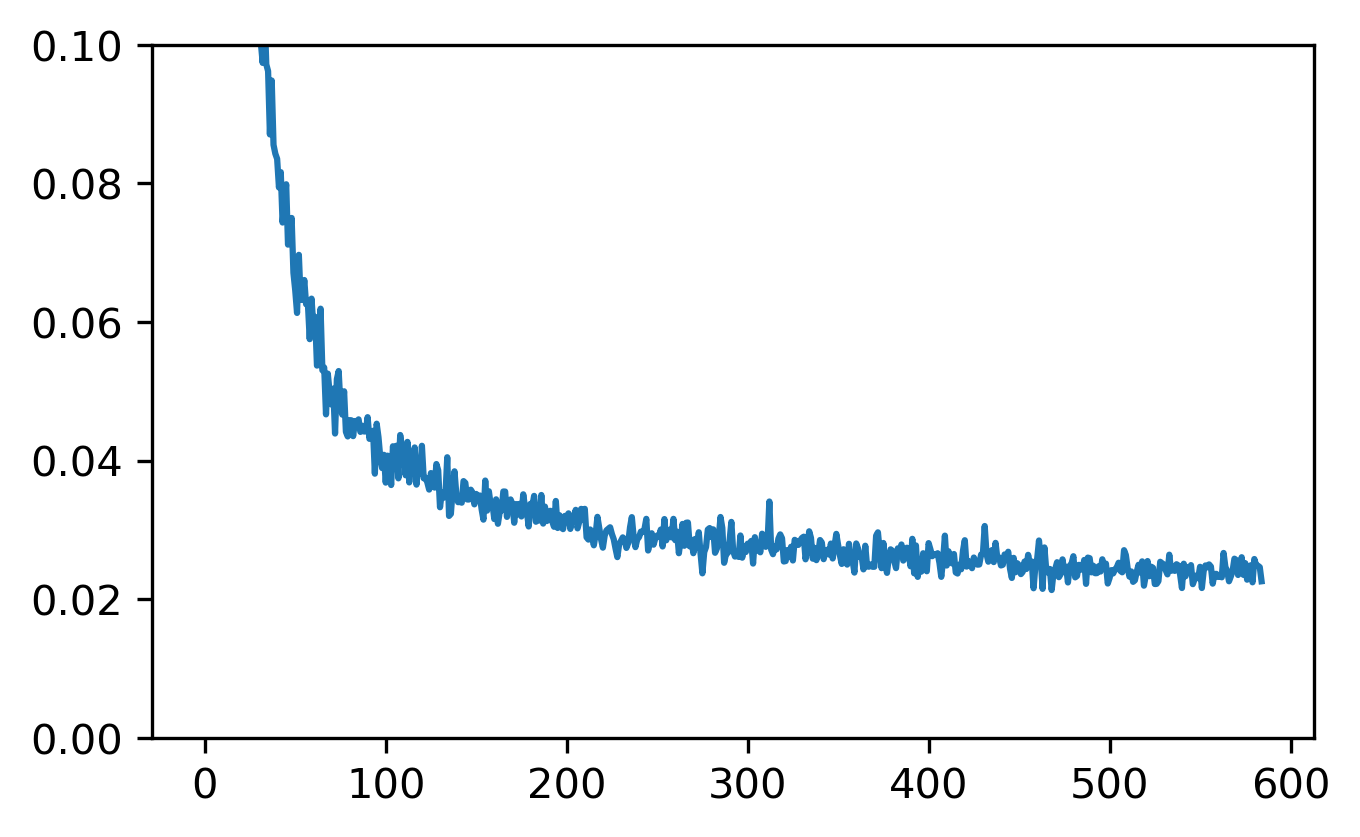

In [11]:
batch_size = 512
dataset = TensorDataset(data)
train_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
)

n_epochs = 5

from Unet import DDPM_Unet

model = DDPM_Unet(1, [32, 32, 64]).cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
best_loss = 1e10
losses = []
for epoch in range(n_epochs):
    for x in tqdm(train_dataloader):
        x = x[0].to(device)
        t = torch.randint(0, T, (x.shape[0],)).to(device)
        x_t, noise = get_noise_image(x, t)
        x_t = x_t.to(device)
        noise = noise.to(device)
        predicted_noise = model(x_t, t)
        loss = criterion(predicted_noise, noise)

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average loss for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_model.pt")
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.5f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

In [12]:
from Unet import DDPM_Unet

# model = DDPM_Unet(1, [32, 32, 64]).cuda()
# model.load_state_dict(torch.load("best_model.pt"))
with torch.no_grad():
    model.eval()
    x = torch.randn((9, 1, 32, 32)).to(device)
    for i in tqdm(reversed(range(1, T)), position=0):
        t = torch.ones(9, dtype=torch.long, device=device) * i
        predicted_noise = model(x, t)
        alpha = alphas[t][:, None, None, None]
        alpha_bar = alphas_bar[t][:, None, None, None]
        beta = betas[t][:, None, None, None]

        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (
            1
            / torch.sqrt(alpha)
            * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise)
            + torch.sqrt(beta) * noise
        )

999it [00:02, 402.29it/s]


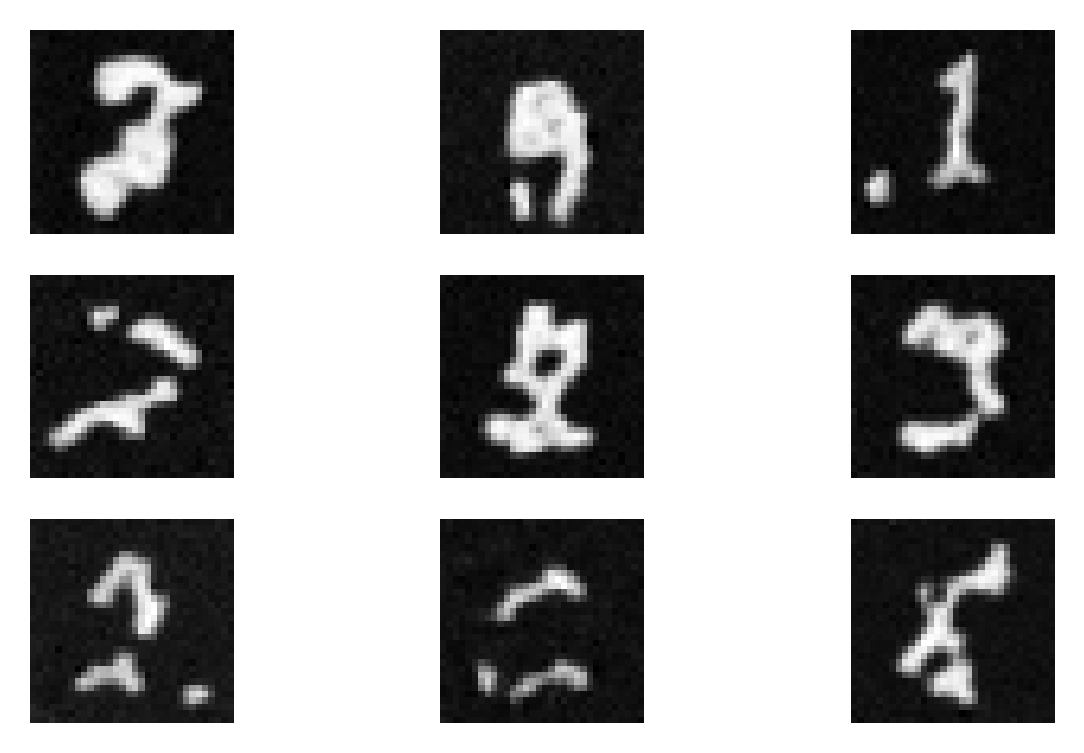

In [13]:
x = x.cpu().detach()
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 300
h, n = 3, 9
for i in range(n):
    plt.subplot(h, h, i + 1)
    plt.axis("off")
    plt.imshow(x[i, 0], cmap="gray")

In [8]:
from Unet import DDPM_Unet
from diffusion import GaussianDiffusion
from diffusion import Trainer

Unet = DDPM_Unet(1, [32, 64, 64])
diffusion = GaussianDiffusion(Unet, 1e-4, 1e-2, 3000)
data_path = "/home/sonwe1e/WorkStation/Dataset/MNIST/images/"
trainer = Trainer(diffusion, data_path, batch_size=256, image_size=32)
# trainer.train(5)

In [9]:
import torch

diffusion.model.load_state_dict(torch.load("best_model.pt"))
a = diffusion.sample(9, 3000, (1, 32, 32))

2999it [00:05, 525.38it/s]


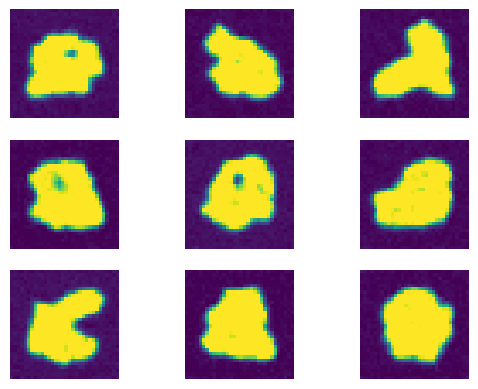

In [10]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis("off")
    plt.imshow(torch.clamp(a[0][i].permute(1, 2, 0).cpu(), 0, 1))

In [11]:
import cv2

for i in range(2999):
    cv2.imwrite(
        f"./generated_samples/{i:03d}.jpg", 255 * a[1][i][0, 0].cpu().detach().numpy()
    )

In [15]:
from PIL import Image
import glob
import os


def create_gif(image_folder, gif_name, duration):
    # 获取指定目录下的所有图片路径
    images = sorted(glob.glob(f"{image_folder}/*.jpg"))

    # 读取图片
    frames = [Image.open(image) for image in images]

    # 保存为GIF
    frame_one = frames[0]
    frame_one.save(
        gif_name,
        format="GIF",
        append_images=frames,
        save_all=True,
        duration=duration,
        loop=0,
    )


def create_mp4(image_folder, mp4_name, fps):
    import cv2

    # 获取图片列表
    images = sorted(glob.glob(f"{image_folder}/*.jpg"))
    images = sorted(images, key=lambda x: int(os.path.basename(x)[:-4]))

    # 确定视频分辨率
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape

    # 定义视频编码和输出
    video = cv2.VideoWriter(
        mp4_name, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height)
    )

    for image in images:
        video.write(cv2.imread(image))


# 调用函数生成GIF和MP4
# 注意：请根据实际图片存放路径和期望的文件名修改以下参数
image_folder = "./generated_samples"  # 图片所在文件夹
create_gif(image_folder, "output.gif", duration=10)  # 持续时间以毫秒为单位
create_mp4(image_folder, "output.mp4", fps=300)  # 每秒帧数

In [14]:
len(image_files)

999